# email

In [2]:
import re
import pandas as pd
import glob
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import string as st
import random as ra
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
txt_files = glob.glob("data/*")

In [4]:
def find_emails(file_name):
    
    with open(file_name, 'rt') as message:
        file = message.read()
        
    file = file.replace("\n", " ")
    exp = "[\w\.\+\-\!\?\*#$%&'=]+@[\w]+\.+[\w-]+"
    emails = re.findall(exp, file)

    return emails



In [5]:
emails = map(find_emails, txt_files)
flattened = set(chain.from_iterable(emails))
email_list = list(set(map(lambda x: x.strip("'"), flattened)))
pd.to_pickle(email_list, "email_list")

# Simple character vectorization of emails

In [6]:
vectorizer = CountVectorizer(analyzer='char', lowercase=False, ngram_range=(1,1))
vectorizer = vectorizer.fit(email_list)
email_vect.shape
email_vect = vectorizer.transform(email_list)
transformer = TfidfTransformer()
email_vect = transformer.fit_transform(email_vect)


In [7]:
email_vect.shape

(5358, 74)

In [8]:
vectorizer.get_feature_names();

In [9]:
sims = cosine_distances(email_vect)
n_dim, m_dim = sims.shape
sims= np.triu(sims, k=1)

# finding most similar pairs to check

In [10]:
top5 = np.argpartition(sims, 5, axis=None)[:5]
n_dim, m_dim = sims.shape
top5_indicesnp_1 = [int(x/m_dim) for x in top5]
top5_indicesnp_2 = [x%m_dim for x in top5]
top5_indicesnp = (tuple(top5_indicesnp_1),tuple(top5_indicesnp_2))
top5_indices = list(map((lambda x : (int(x/m_dim), x%m_dim) ), (top5)))


In [11]:
top5_indices

[(3585, 1165), (3585, 1167), (3585, 1163), (3585, 1164), (3585, 1161)]

In [12]:
sims[top5_indicesnp]

array([0., 0., 0., 0., 0.])

In [13]:
email_list[3585],email_list[1160]

('santana@enron.com', 'tina.spiller@enron.com')

# other ideas

cosine similarity is good, the trick is encoding the emails as vectors in a way that makes sense.
there are two different things to look at:

- changing tokens to something like uppercase, lowercase, symbol, number or even using dictionaries of names or words to do word, name, symbol, number

- adding in some dependence on order; right now anagrams will have similarity of 1. could change tokens to ngrams or directional transitions, ie a->b, a->c, etc. would be the vector space. 

the next goal is to do something combining these- where we look at uppercase->lowercase->symbol etc. transitions

# New dictionary

In [14]:
vectorizer = CountVectorizer(analyzer='char', lowercase=False)
vectorizer = vectorizer.fit(email_list)


In [15]:
symbols = vectorizer.get_feature_names()

In [16]:
vocab2 = {}
for char in symbols:
    if char in st.ascii_lowercase:
        vocab2[char]=0
    elif char in st.ascii_uppercase:
        vocab2[char]=1
    elif char in st.digits:
        vocab2[char]=2
    else:
        vocab2[char]=3
vocab2['"'] = 4

In [17]:
vocab2;

In [18]:
def token_mapper(list_of_string, dictionary):
    str1 = [''.join(str(e) for e in list(map(dictionary.get, string))) for string in list_of_string] 
    return str1

In [19]:
mapped = token_mapper(email_list, vocab2)

In [20]:
mapped;

In [21]:
# vectorizer2=CountVectorizer(analyzer='char')
# vectors2 = vectorizer2.fit_transform(mapped)

In [22]:
#try with ngrams
vectorizer2=CountVectorizer(analyzer='char', ngram_range=(3,4))
vectors2 = vectorizer2.fit_transform(mapped)
transformer = TfidfTransformer()
vectors2 = transformer.fit_transform(vectors2)

In [23]:
vectors2.shape

(5358, 240)

In [24]:
# scaler = StandardScaler()
# vectors2_scaled = scaler.fit_transform(vectors2.toarray())

In [25]:
sims = cosine_distances(vectors2)
n_dim, m_dim = sims.shape
sims= np.triu(sims, k=1)

In [26]:
sims

array([[0.        , 0.24202412, 0.00065373, ..., 0.        , 0.00790394,
        0.00790394],
       [0.        , 0.        , 0.23771619, ..., 0.24202412, 0.23134315,
        0.23134315],
       [0.        , 0.        , 0.        , ..., 0.00065373, 0.00401601,
        0.00401601],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00790394,
        0.00790394],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [27]:
top5 = np.argpartition(sims, -5, axis=None)[-5:]
n_dim, m_dim = sims.shape
top5_indicesnp_1 = [int(x/m_dim) for x in top5]
top5_indicesnp_2 = [x%m_dim for x in top5]
top5_indicesnp = (tuple(top5_indicesnp_1),tuple(top5_indicesnp_2))
top5_indices = list(map((lambda x : (int(x/m_dim), x%m_dim) ), (top5)))


In [28]:
top5_indices

[(1076, 4645), (1168, 4226), (2000, 4177), (1124, 1669), (2290, 2793)]

In [29]:
sims[top5_indicesnp]

array([1., 1., 1., 1., 1.])

In [30]:
email_list[125],email_list[726]

('david.loosley@enron.com', 'la.rose@enron.com')

# checkpoint

In [31]:
# ap = AffinityPropagation(affinity = 'precomputed')
# ap.fit(sims)

In [32]:
ag= AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage='complete', distance_threshold=.8 )
ag.fit(sims)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.8,
                        linkage='complete', memory=None, n_clusters=None)

In [33]:
df = pd.DataFrame(vectors2)

In [34]:
#df = pd.DataFrame(email_vect)

In [35]:
# vectors2_centered = vectors2-np.average(vectors2.toarray(), axis=0)

In [36]:
# nmf = NMF(n_components = 20)
# dim2 = nmf.fit_transform(vectors2)

In [37]:
scaler = StandardScaler()
vectors2_scaled = scaler.fit_transform(vectors2.toarray())
svd = PCA(n_components = 80)
dim2 = svd.fit_transform(vectors2_scaled)


In [38]:
svd.explained_variance_ratio_.sum()

0.9498713655215418

In [39]:
tsne = TSNE(metric = 'cosine')
dim3 = tsne.fit_transform(dim2)

In [40]:
dim2.shape

(5358, 80)

In [41]:
ag2= AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage='complete', distance_threshold=.8 )
ag2.fit(sims)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.8,
                        linkage='complete', memory=None, n_clusters=None)

In [42]:
df['labels'] = ag2.labels_

In [43]:
dim2;

In [44]:
df2d = pd.DataFrame(dim3)
df2d['label'] = df['labels']
#df2d[0] = np.round(df2d[0], 3)
#df2d[1] = np.round(df2d[1], 3)
df2d.max()

0        62.240246
1        78.083679
label    16.000000
dtype: float64

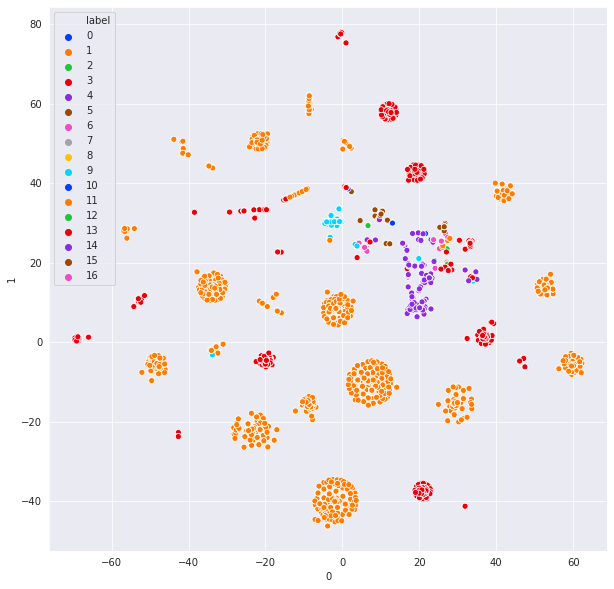

In [45]:
sns.set_style("darkgrid")

g = sns.scatterplot(x = df2d[0], y = df2d[1], hue = df2d['label'], palette='bright')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [132]:
label_group = list(df2d.loc[df2d.label==16].index)
print([email_list[ind] for ind in label_group])

['R-5-728387-3078726-2-6417-US2-1E1994B7@xmr3.com', 'r-3-728402-1640008-2-359-us2-982d4478@xmr3.com', 'R-9-728387-1667935-2-6778-US2-6FF3B621@xmr3.com', 'DES883781@aol.com', 'sta062010+50457355707+jeff.skilling@enron.com', 'leave-participate.com-0110b-10816239R@lyris.postfuture', '5147D82D2EEACF119E650001FA3702F70BF96CF7@exch1.tmh', 'R-3-728402-1640008-2-359-US2-982D4478@xmr3.com', 'leave-participate.com-0109-10010942G@lyris.postfuture', 'BLADE90123@aol.com', 'r-9-728387-1667935-2-6778-us2-6ff3b621@xmr3.com', 'R-6-728387-2981197-2-3244-US2-FF34A999@xmr3.com', 'r-5-728387-3412887-2-6526-us2-7d3e6e54@xmr3.com', '16239R@lyris.postfuture', 'r-3-728387-3217638-2-3294-us2-9cb39b5d@xmr3.com', 'R-8-728387-3559515-2-6560-US2-5236E5B1@xmr3.com', 'r-5-728387-3078726-2-6417-us2-1e1994b7@xmr3.com', '74771.62@compuserve.com', 'r-6-728387-2981197-2-3244-us2-ff34a999@xmr3.com', 'R-5-728387-3412887-2-6526-US2-7D3E6E54@xmr3.com', '75677.1107@compuserve.com', 'R-3-728387-3217638-2-3294-US2-9CB39B5D@xmr3.

# moving on to words and names
 this method seems to be showing promise on this testing data, we will need to do more in-depth checking and testing to gauge performance
 the main problem now is that the measurements seem to be pretty affected by the length of the email address. using dictionaries and/or lists of names will help with this.
 

In [38]:
with open("NamesAll.dic", 'rt', encoding='cp1252') as message:
        file = message.read()
file = file.replace("\n", ",").replace(" ","")
names = file.split(sep=',')
names = list(filter(lambda x: len(x)>3, names))

In [144]:
#test_add = "abashir22@gmail.com"

In [39]:
def name_replace(string, dict):
    for word in dict:
        string2 = string.replace(word, '"')
        if string2 != string:
            return string2
        
    return string

In [40]:
ra.shuffle(names)

In [42]:
#name_replace(test_add, names)

In [43]:
mapped1 = [name_replace(email, names) for email in email_list]

In [67]:
mapped1;

In [45]:
mapped2 = token_mapper(mapped1, vocab2)

In [69]:
mapped2;

In [118]:
#try with ngrams
vectorizer2=CountVectorizer(analyzer='char', ngram_range=(5,5))
vectorizer2 = vectorizer2.fit(mapped2)
vectors2 = vectorizer2.transform(mapped2)

In [119]:
vectors2.shape

(5358, 698)

In [120]:
cols = list(zip(vectorizer2.get_feature_names(), list(range(309))))

In [121]:
nearby_names = list(filter(lambda x : "4" in x[0], cols))
nn_indices = list(map(lambda x : x[1], nearby_names))

In [122]:
vectors3 = vectors2[:,nn_indices]
vectors3.shape

(5358, 125)

In [123]:
sims = cosine_similarity(vectors3)
n_dim, m_dim = sims.shape
sims= np.triu(sims, k=1)

In [124]:
top5 = np.argpartition(sims, -8, axis=None)[-8:]
n_dim, m_dim = sims.shape
top5_indicesnp_1 = [int(x/m_dim) for x in top5]
top5_indicesnp_2 = [x%m_dim for x in top5]
top5_indicesnp = (tuple(top5_indicesnp_1),tuple(top5_indicesnp_2))
top5_indices = list(map((lambda x : (int(x/m_dim), x%m_dim) ), (top5)))


In [125]:
top5_indices

[(2958, 4526),
 (2958, 4531),
 (2958, 4522),
 (2958, 4535),
 (2958, 4568),
 (2958, 4561),
 (2958, 4567),
 (2300, 2785)]

In [103]:
sims[top5_indicesnp]

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [129]:
email_list[2958],email_list[4526]

('wes.dempsey@enron.com', 'ken.rice@enron.com')

This is quite crude at this point, but the dictionary approach seems to be doing what we wanted it to do. 
the dictionary search through the email addressess is very inefficient, but on the irs data we could just use any names on the tax return as a dictionary, which would probably be easy. we would run into some rich, richard, dick matching problems, but for a crude first pass it would be interesting

In [ ]:
ap.fit()

### This is a helper function for changing mapping in the cosine similarity

In [12]:
def token_mapper(list_of_string, dictionary):
    str1 = [''.join(str(e) for e in list(map(dictionary.get, string))) for string in list_of_string] 
    return str(str1)

In [13]:

@f.udf(t.FloatType())
def text_cosine2(col):
    num_rows = len(col)
    num_entries = (num_rows * (num_rows -1))/2
    if num_rows >= 10:
        
        vectorizer1 = TfidfVectorizer(analyzer = "char", lowercase=False)
        vectorizer1 = vectorizer1.fit(col)
        alphabet = vectorizer1.get_feature_names()
        
        alphabet2 = {}
        for char in alphabet:
            if char in st.ascii_lowercase:
                alphabet2[char]=0
            elif char in st.ascii_uppercase:
                alphabet2[char]=1
            elif char in st.digits:
                alphabet2[char]=2
            else:
                alphabet2[char]=3

        mapped = [token_mapper(string, alphabet2) for string in col]
        
        vectorizer2 = TfidfVectorizer(analyzer="char", ngram_range=(2,4), lowercase=False)
        vectors = vectorizer2.fit_transform(mapped)
        cosines = cosine_similarity(vectors)
        cosines = np.triu(cosines, k=1)
        
        return float(cosines.sum() / num_entries)
    
    else:
        return None

In [14]:
result = email_df.groupBy("label").agg(
    text_cosine2(f.collect_list("email")),
    text_cosine2(f.collect_list("names"))
)

In [15]:
result.show()

+-----+---------------------------------------+---------------------------------------+
|label|text_cosine2(collect_list(email, 0, 0))|text_cosine2(collect_list(names, 0, 0))|
+-----+---------------------------------------+---------------------------------------+
|    1|                              0.9257102|                               0.923891|
|    3|                             0.93182456|                              0.9336492|
|    2|                             0.92458904|                              0.9289542|
|    4|                              0.9294994|                             0.92509425|
+-----+---------------------------------------+---------------------------------------+

